# Import computation and plotting library

In [8]:
from datetime import datetime, timedelta
from math import sqrt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from model.sat_pos_calc import SatellitePositionCalc

# Configure data and output files

In [9]:
NAV_FILE = '../data/brdc2360.18n'
SP3_FILE = '../data/brdc2360.sp3'
POS_FILE = '../data/brdc2360.pos'

# Initialize calculation class

In [10]:
calc = SatellitePositionCalc(NAV_FILE)
sp3 = pd.read_table(SP3_FILE, sep=r'\s+', header=0)

In [11]:
PRN_LIST = [f'G{i:02n}' for i in range(1, 33)]
print(PRN_LIST)

['G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 'G17', 'G18', 'G19', 'G20', 'G21', 'G22', 'G23', 'G24', 'G25', 'G26', 'G27', 'G28', 'G29', 'G30', 'G31', 'G32']


# Calculate position of satellite G01 in 2018-08-24 01:00:00

In [12]:
def calc_3d_point_error(p1, p2):
    dx_dy_dz = [i - j for i, j in zip(p1, p2)]
    ds = sqrt(sum([k ** 2 for k in dx_dy_dz]))
    return ds, dx_dy_dz


def calc_sod(t):
    return t.hour * 3600 + t.minute * 60 + t.second


def evaluate_precision(prn, calc_time, computed_pos, allow_print=True):
    """Evaluate error of instant satellite position by compare calculated and .sp3 data"""
    sod = calc_sod(calc_time)
    try:
        xyz_sp3 = sp3[(sp3['prn'] == prn) & (sp3['sod'] == sod)].values[0, -3:]
    except IndexError:
        print(f'No Such SP3 Data in {calc_time}(sod {sod}) of prn {prn}')
        return

    sp3_err, sp3_delta = calc_3d_point_error(xyz_sp3, computed_pos)
    if allow_print:
        print(f'Calculated Position of {prn} in {calc_time}\n{computed_pos}')
        print(f'Difference of X Y Z between .sp3 and calculated position\n{sp3_delta}')
        print(f'Error between .sp3 and calculated position {sp3_err}')
        print()
    return sp3_err

which means the **nearest ephemeris** to the calculated time is most precise of all

The following step has proved the conclusion

# Evaluate precision of satellite position using different ephemeris

## Errors of satellite G01 with the time span of [-60, -30, 0, 30, 60] minutes

In [13]:
prn = "G01"
nav_times = [
    datetime(2018, 8, 24, 0, 0, 0),
    datetime(2018, 8, 24, 1, 30, 0),
]
calc_time = datetime(2018, 8, 24, 1, 0, 0)

for nav_time in nav_times:
    xyz = calc.calc_specified_time(prn, nav_time=nav_time, calc_time=calc_time)
    evaluate_precision(prn, calc_time, xyz, allow_print=True)

Calculated Position of G01 in 2018-08-24 01:00:00
[-13205373.79115928, 15498126.605381792, 16724633.352198847]
Difference of X Y Z between .sp3 and calculated position
[-0.12784072197973728, -1.4193817935883999, 0.5648011546581984]
Error between .sp3 and calculated position 1.5329671459198848

Calculated Position of G01 in 2018-08-24 01:00:00
[-13205369.020404302, 15498123.151404062, 16724627.009004006]
Difference of X Y Z between .sp3 and calculated position
[-4.89859570004046, 2.034595936536789, 6.907995995134115]
Error between .sp3 and calculated position 8.709548158556554



In [14]:
prn_nav_data = calc.RINEX.get_nav_data(PRN=prn)
nav_times = list(map(lambda bl: bl.toc, prn_nav_data))

errs_list = []
time_span = np.array([timedelta(minutes=i * 30) for i in range(-2, 3)])
for nav_time in nav_times:
    calc_times = nav_time + time_span 
    diff_span_err = []
    for calc_time in calc_times:
        xyz = calc.calc_specified_time(prn, nav_time, calc_time)
        err = evaluate_precision(prn, calc_time, xyz, allow_print=False)
        diff_span_err.append(err)
    errs_list.append(diff_span_err)
col_labs = [f'{i.total_seconds() / 60} minutes' for i in time_span]
df_errs = pd.DataFrame(errs_list, columns=col_labs, index=nav_times)

No Such SP3 Data in 2018-08-24 14:59:44(sod 53984) of prn G01
No Such SP3 Data in 2018-08-24 15:29:44(sod 55784) of prn G01
No Such SP3 Data in 2018-08-24 15:59:44(sod 57584) of prn G01
No Such SP3 Data in 2018-08-24 16:29:44(sod 59384) of prn G01
No Such SP3 Data in 2018-08-24 16:59:44(sod 61184) of prn G01
No Such SP3 Data in 2018-08-24 16:59:44(sod 61184) of prn G01
No Such SP3 Data in 2018-08-24 17:29:44(sod 62984) of prn G01
No Such SP3 Data in 2018-08-24 17:59:44(sod 64784) of prn G01
No Such SP3 Data in 2018-08-24 18:29:44(sod 66584) of prn G01
No Such SP3 Data in 2018-08-24 18:59:44(sod 68384) of prn G01


note that some ephemeris do not have corresponding sp3 data(which cause **`NaN` values**) and some time exceed the day (which cause **huge errors**).We drop them all

In [15]:
df_errs[np.abs(df_errs) > 1e3] = np.nan
df_errs = df_errs[~np.isnan(df_errs).all(axis=1)]
df_errs

,-60.0 minutes,-30.0 minutes,0.0 minutes,30.0 minutes,60.0 minutes
2018-08-24 00:00:00,NaN,NaN,1.506894,1.473928,1.532967
2018-08-24 01:30:00,18.566868,8.709548,1.658397,9.477892,19.299025
2018-08-24 02:00:00,1.784830,1.368424,1.222829,1.461012,1.721546
2018-08-24 03:30:00,32.027985,15.064341,1.485728,14.435496,31.475160
2018-08-24 04:00:00,1.198267,1.518325,1.592226,1.288520,0.931099
2018-08-24 05:30:00,23.588687,10.689191,1.265532,11.530801,24.355238
2018-08-24 06:00:00,1.248408,1.112657,1.112692,1.226499,1.234784
2018-08-24 07:30:00,28.431586,13.592920,1.443787,12.341288,27.192548
2018-08-24 08:00:00,1.089411,1.408391,1.514341,1.444226,1.465920
2018-08-24 09:30:00,47.752329,21.824468,1.845079,23.153984,49.124184


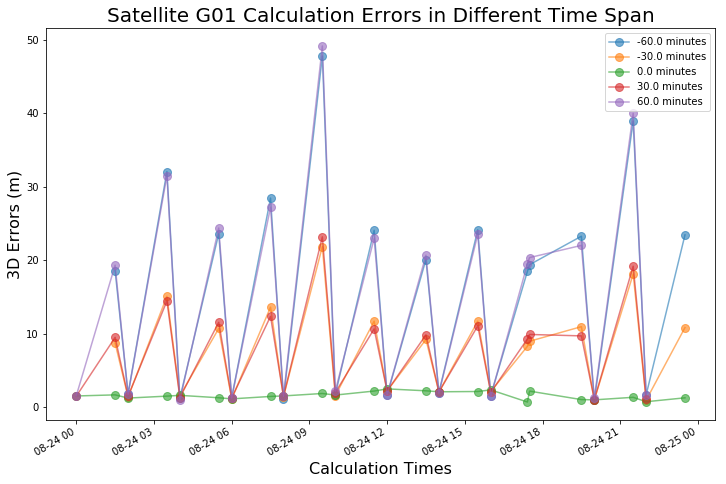

In [16]:
ax = df_errs.plot(figsize=(12, 8), style='o-', markersize=8, alpha=.6)
ax.set_title('Satellite G01 Calculation Errors in Different Time Span', fontsize=20)
ax.set_xlabel('Calculation Times', fontsize=16)
ax.set_ylabel('3D Errors (m)', fontsize=16)
toe = df_errs.index.to_pydatetime()
ax.legend()
# plt.savefig('Errors.jpg')

# Calculate and draw satellite orbits of

- Satellites: G01 - G32
- Calculated times: from 00:00:00 to 23:45:00
- Steps: 30s

In [17]:
start_date_time = datetime(2018, 8, 24, 0, 0, 0)
end_date_time = datetime(2018, 8, 24, 23, 45, 0)
nums = int((end_date_time - start_date_time).total_seconds() / 30)
orbit_dict = {}
for prn in PRN_LIST:
    df_orbit = calc.calc_sat_orbit(prn, start_date_time, end_date_time)
    orbit_dict[prn] = df_orbit
    print(f'{prn} finished')

G01 finished
G02 finished
G03 finished
G04 finished
G05 finished
G06 finished
G07 finished
G08 finished
G09 finished
G10 finished
G11 finished
G12 finished
G13 finished
G14 finished
G15 finished
G16 finished
G17 finished
G18 finished
G19 finished
G20 finished
G21 finished
G22 finished
G23 finished
G24 finished
G25 finished
G26 finished
G27 finished
G28 finished
G29 finished
G30 finished
G31 finished
G32 finished


For conveience, we just plot the first 3 satellite orbits

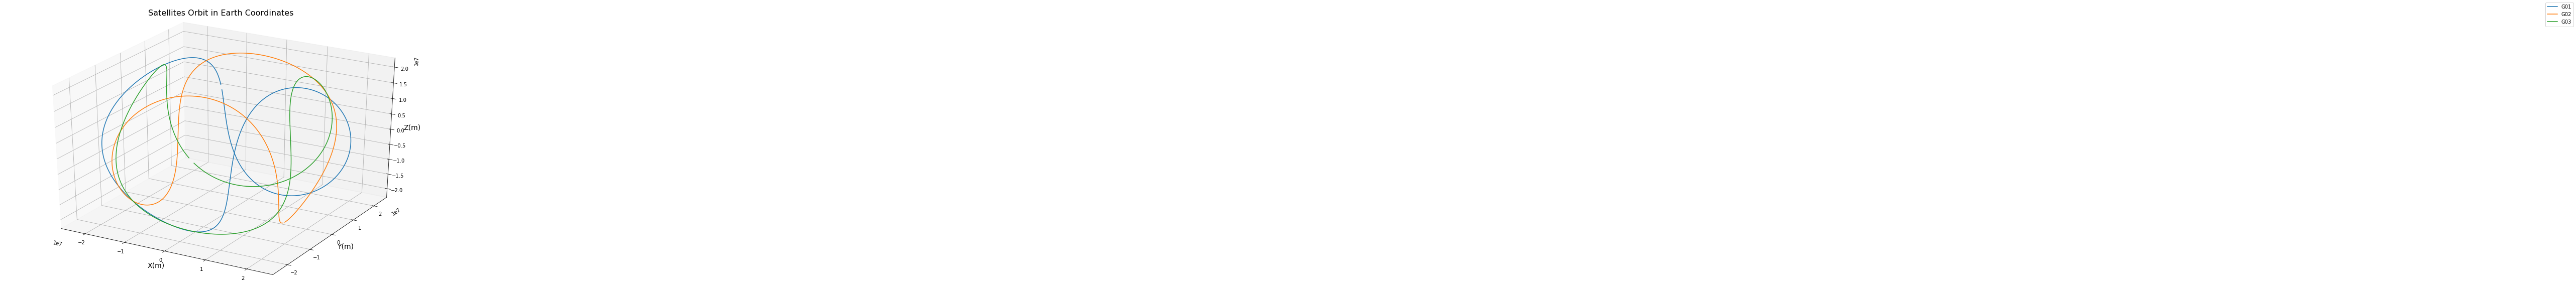

In [28]:
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig)
ax.set_xlabel("X(m)", fontsize=14)
ax.set_ylabel("Y(m)", fontsize=14)
ax.set_zlabel("Z(m)", fontsize=14)
for prn in PRN_LIST[:3]:
    orbit = orbit_dict[prn]
    ax.plot(xs=orbit['x'], ys=orbit['y'], zs=orbit['z'], label=prn)
fig.suptitle(f"Satellites Orbit in Earth Coordinates", fontsize=16)
fig.legend()
# fig.savefig('Orbits.jpg')

# Output the orbits data

In [19]:
CALC_FILE = 'orbit.txt'

In [20]:
output_data = pd.concat(list(orbit_dict.values()))
output_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91232 entries, 2018-08-24 00:00:00 to 2018-08-24 23:45:00
Data columns (total 5 columns):
sod    91232 non-null int32
prn    91232 non-null object
x      91232 non-null float64
y      91232 non-null float64
z      91232 non-null float64
dtypes: float64(3), int32(1), object(1)
memory usage: 3.8+ MB


In [21]:
def out_data(row, f):
    sod, prn, x, y, z = row
    print(f'{sod:<6n}{prn:<6s}{x:<15.3f}{y:<15.3f}{z:<15.3f}', file=f)

In [22]:
with open(CALC_FILE, 'w') as f:
    print(f'{"sod":<6s}{"prn":<6s}{"x":<15s}{"y":<15s}{"z":<15}', file=f)
    output_data.apply(out_data, axis=1, args=(f, ))